In [ ]:
!wget https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip

--2022-10-04 14:59:37--  https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c0:3470, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105946856 (101M) [application/zip]
Saving to: ‘fruits.zip’

fruits.zip          100%[===================>] 101.04M   225MB/s    in 0.4s    

2022-10-04 14:59:41 (225 MB/s) - ‘fruits.zip’ saved [105946856/105946856]



In [ ]:
!unzip fruits.zip

Archive:  fruits.zip
   creating: fruits/
  inflating: __MACOSX/._fruits       
  inflating: fruits/.DS_Store        
  inflating: __MACOSX/fruits/._.DS_Store  
   creating: fruits/test/
   creating: fruits/train/
   creating: fruits/validation/
   creating: fruits/test/apple/
  inflating: fruits/test/.DS_Store   
  inflating: __MACOSX/fruits/test/._.DS_Store  
   creating: fruits/test/banana/
   creating: fruits/test/orange/
   creating: fruits/train/apple/
  inflating: fruits/train/.DS_Store  
  inflating: __MACOSX/fruits/train/._.DS_Store  
   creating: fruits/train/banana/
   creating: fruits/train/orange/
   creating: fruits/validation/apple/
  inflating: fruits/validation/.DS_Store  
  inflating: __MACOSX/fruits/validation/._.DS_Store  
   creating: fruits/validation/banana/
   creating: fruits/validation/orange/
  inflating: fruits/test/apple/Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflating: __MACOSX/fruits/test/apple/._Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflatin

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 460 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Found 130 files belonging to 3 classes.


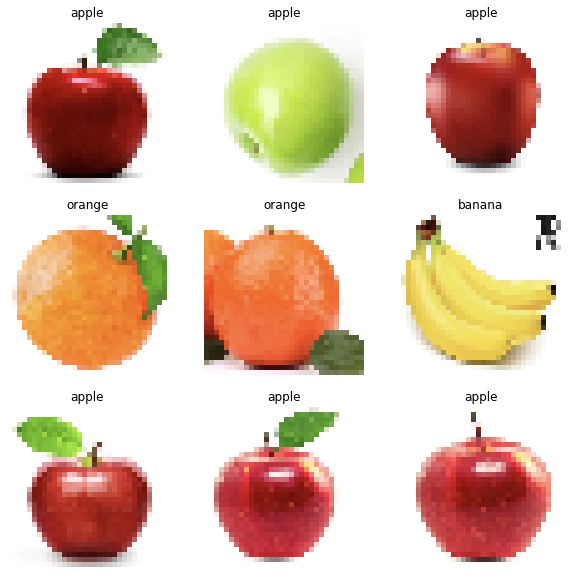

In [ ]:
class_names = ["apple", "banana", "orange"]
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(3)
    ]
)


In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Epoch 1/10
23/23 [==============================] - 17s 125ms/step - loss: 0.9545 - accuracy: 0.5826 - val_loss: 0.7848 - val_accuracy: 0.4697
Epoch 2/10
23/23 [==============================] - 2s 49ms/step - loss: 0.5908 - accuracy: 0.7739 - val_loss: 0.7201 - val_accuracy: 0.6212
Epoch 3/10
23/23 [==============================] - 2s 48ms/step - loss: 0.5670 - accuracy: 0.7326 - val_loss: 0.4139 - val_accuracy: 0.8333
Epoch 4/10
23/23 [==============================] - 2s 49ms/step - loss: 0.3634 - accuracy: 0.8717 - val_loss: 0.2593 - val_accuracy: 0.8939
Epoch 5/10
23/23 [==============================] - 2s 49ms/step - loss: 0.3311 - accuracy: 0.8652 - val_loss: 0.4680 - val_accuracy: 0.7576
Epoch 6/10
23/23 [==============================] - 2s 49ms/step - loss: 0.2465 - accuracy: 0.9174 - val_loss: 0.1377 - val_accuracy: 0.9697
Epoch 7/10
23/23 [==============================] - 2s 50ms/step - loss: 0.1468 - accuracy: 0.9587 - val_loss: 0.1906 - val_accuracy: 0.9091
Epoch 8/10


In [ ]:
model.evaluate(test_ds)

7/7 [==============================] - 0s 13ms/step - loss: 0.1260 - accuracy: 0.9692


[0.12602630257606506, 0.9692307710647583]

In [ ]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])
  
  if(class_names[index] != class_names[labels[i]]):
    print("Wrong prediction")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)